In [2]:
#hide
#!pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [ ]:
#hide
from fastbook import *

# Analyse approfondie du filtrage collaboratif

Un problème très courant à résoudre est lorsque vous avez un certain nombre d'utilisateurs et un certain nombre de produits, et que vous souhaitez recommander les produits les plus susceptibles d'être utiles pour quels utilisateurs. Il existe de nombreuses variantes de cela: par exemple, recommander des films (comme sur Netflix), déterminer ce qu'il faut mettre en évidence pour un utilisateur sur une page d'accueil, décider des histoires à afficher dans un flux de médias sociaux, etc. Il existe une solution générale à ce problème, appelée *filtrage collaboratif*, qui fonctionne comme ceci: regardez quels produits l'utilisateur actuel a utilisé ou aimé, trouvez d'autres utilisateurs qui ont utilisé ou aimé des produits similaires, puis recommandez d'autres produits que ceux-ci les utilisateurs ont utilisé ou aimé.

Par exemple, sur Netflix, vous avez peut-être regardé de nombreux films de science-fiction et d'actions réalisés dans les années 1970. Netflix ne connaît peut-être pas ces propriétés particulières des films que vous avez regardés, mais il pourra voir que d'autres personnes qui ont regardé les mêmes films que vous avez regardés avaient également tendance à regarder d'autres films de science-fiction, pleins d'action et qui ont été réalisés dans les années 1970. En d'autres termes, pour utiliser cette approche, nous n'avons pas nécessairement besoin de savoir quoi que ce soit sur les films, sauf qui aime les regarder.

Il existe en fait une classe plus générale de problèmes que cette approche peut résoudre, n'impliquant pas nécessairement les utilisateurs et les produits. En effet, pour le filtrage collaboratif, nous nous référons plus communément à des *articles* qu'à des *produits*. Les éléments peuvent être des liens sur lesquels les internautes cliquent, des diagnostics sélectionnés pour les patients, etc.

L'idée fondamentale clé est celle des *facteurs latents*. Dans l'exemple Netflix, nous avons commencé par supposer que vous aimez les vieux films de science-fiction bourrés d'action. Mais vous n'avez jamais dit à Netflix que vous aimez ce genre de films. Et Netflix n'a jamais eu besoin d'ajouter des colonnes à son tableau de films indiquant quels films sont de ces types. Pourtant, il doit y avoir un concept sous-jacent de la science-fiction, de l'action et de l'âge du cinéma, et ces concepts doivent être pertinents pour au moins les décisions de regarder des films de certaines personnes.

Pour ce chapitre, nous allons travailler sur ce problème de recommandation de films. Nous allons commencer par obtenir des données adaptées à un modèle de filtrage collaboratif.

## Un premier regard sur les données

Nous n'avons pas accès à l'ensemble de données de Netflix sur l'historique de visionnage de films, mais il existe un excellent ensemble de données que nous pouvons utiliser, appelé [MovieLens](https://grouplens.org/datasets/movielens/). Cet ensemble de données contient des dizaines de millions de classements de films (une combinaison d'un ID de film, d'un ID utilisateur et d'une note numérique), bien que nous n'utilisons qu'un sous-ensemble de 100 000 d'entre eux pour notre exemple. Si vous êtes intéressé, ce serait un excellent projet d'apprentissage d'essayer de reproduire cette approche sur l'ensemble de données de recommandations de 25 millions, que vous pouvez obtenir sur leur site Web.



L'ensemble de données est disponible via la fonction fastai habituelle:

In [3]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [4]:
! cat {str(path/'README')}

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

Selon le *README*, la table principale se trouve dans le fichier *u.data*. Il est séparé par des tabulations et les colonnes sont respectivement utilisateur, film, classement et horodatage. Puisque ces noms ne sont pas encodés (voir ci-dessus: 0, ..., 3), nous devons les indiquer lors de la lecture du fichier avec Pandas. Voici un moyen d'ouvrir ce tableau et de jeter un œil:

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [55]:
ratings[ratings.user==196].shape

(39, 5)

In [62]:
user_idX = 196
movie_idX = 3

In [64]:
# ratings[ratings.movie==movie_idX]

In [56]:
movie_ids = ratings[ratings.user==196].movie

In [60]:
sorted(movie_ids.unique())

[8,
 13,
 25,
 66,
 67,
 70,
 94,
 108,
 110,
 111,
 116,
 153,
 173,
 202,
 238,
 242,
 251,
 257,
 269,
 285,
 286,
 287,
 306,
 340,
 381,
 382,
 393,
 411,
 428,
 580,
 655,
 663,
 692,
 762,
 845,
 1007,
 1022,
 1118,
 1241]

Bien que cela contienne toutes les informations dont nous avons besoin, ce n'est pas un moyen particulièrement utile pour les humains de consulter ces données. <<movie_xtab>> affiche les mêmes données croisées dans un tableau convivial.

<img alt="Crosstab of movies and users" width="632" caption="Crosstab of movies and users" id="movie_xtab" src="images/att_00040.png">

Pour cet exemple de tableau croisé, nous n'avons sélectionné que quelques-uns des films les plus populaires et des utilisateurs qui regardent le plus de films. Les cellules vides de ce tableau sont les éléments que nous aimerions que notre modèle apprenne à remplir. Ce sont les endroits où un utilisateur n'a pas encore revu le film, probablement parce qu'il ne l'a pas regardé. Pour chaque utilisateur, nous aimerions savoir lequel de ces films il serait le plus susceptible d'apprécier.

Si nous savions pour chaque utilisateur dans quelle mesure il aimait chaque catégorie importante dans laquelle un film pourrait appartenir, comme le genre, l'âge, les réalisateurs et acteurs préférés, etc., et que nous connaissions les mêmes informations sur chaque film, alors un moyen simple remplir ce tableau reviendrait à multiplier ces informations pour chaque film et à utiliser une combinaison. Par exemple, en supposant que ces facteurs varient entre -1 et +1, avec des nombres positifs indiquant des correspondances plus fortes et des nombres négatifs plus faibles, et que les catégories sont la science-fiction, l'action et les vieux films, alors nous pourrions représenter le film *The Last Skywalker* comme:

In [37]:
last_skywalker = np.array([0.98,0.9,-0.9])

Ici, par exemple, nous notons *très science-fiction* 0,98, *très action* 0,9 et *très pas vieux* -0,9. Nous pourrions représenter un utilisateur qui aime les films d'action de science-fiction modernes comme:

In [5]:
user1 = np.array([0.9,0.8,-0.6])

et nous pouvons maintenant calculer la correspondance entre cette combinaison:

In [6]:
(user1*last_skywalker).sum()

2.1420000000000003

Lorsque nous multiplions deux vecteurs ensemble et additionnons les résultats, cela s'appelle le *produit scalaire*. Il est beaucoup utilisé dans l'apprentissage automatique et constitue la base de la multiplication matricielle. Nous examinerons beaucoup plus la multiplication matricielle et les produits scalaires dans <<chapter_foundations>>.

> jargon: produit scalaire: opération mathématique consistant à multiplier les éléments de deux vecteurs ensemble, puis à additionner le résultat.

D'un autre côté, nous pourrions représenter le film *Casablanca* comme:

In [7]:
casablanca = np.array([-0.99,-0.3,0.8])

La correspondance entre cette combinaison est:

In [8]:
(user1*casablanca).sum()

-1.611

Puisque nous ne savons pas quels sont réellement les facteurs latents et que nous ne savons pas comment les noter pour chaque utilisateur et chaque film, nous devons les apprendre.

## Apprendre les facteurs latents

Il y a étonnamment peu de différence entre la spécification de la structure d'un modèle, comme nous l'avons fait dans la dernière section, et en apprendre une, puisque nous pouvons simplement utiliser notre approche générale de descente de gradient.

L'étape 1 de cette approche consiste à initialiser aléatoirement certains paramètres. Ces paramètres seront un ensemble de facteurs latents pour chaque utilisateur et chaque film. Nous devrons décider du nombre à utiliser. Nous allons discuter de la façon de sélectionner cela sous peu, mais à des fins d'illustration, utilisons 5 pour le moment. Étant donné que chaque utilisateur aura un ensemble de ces facteurs et que chaque film aura un ensemble de ces facteurs, nous pouvons afficher ces valeurs initialisées au hasard juste à côté des utilisateurs et des films dans notre tableau croisé, et nous pouvons ensuite remplir les produits scalaires pour chaque de ces combinaisons au milieu. Par exemple, <<xtab_latent>> montre à quoi il ressemble dans Microsoft Excel, avec la formule de cellule en haut à gauche affichée à titre d'exemple.

<img alt="Latent factors with crosstab" width="900" caption="Latent factors with crosstab" id="xtab_latent" src="images/att_00041.png">

In [38]:
user29 = np.array([1.55, .75, .22, 1.62, 1.26])
movie27 = np.array([-1.69, 1.01, .82, 1.89, 2.39])
user29.dot(movie27)

4.3916

L'étape 2 de cette approche consiste à calculer nos prédictions. Comme nous l'avons vu, nous pouvons le faire en prenant simplement le produit scalaire de chaque film avec chaque utilisateur. Si, par exemple, le premier facteur d'utilisateur latent représente à quel point l'utilisateur aime les films d'action et le premier facteur de film latent représente si le film a beaucoup d'action ou non, le produit de ceux-ci sera particulièrement élevé si l'utilisateur aime l'action et le film contient beaucoup d'action ou l'utilisateur n'aime pas les films d'action et le film ne contient aucune action. D'un autre côté, si nous avons une discordance (un utilisateur aime les films d'action mais le film n'est pas un film d'action, ou l'utilisateur n'aime pas les films d'action et ça en est  un), le produit sera très bas.

L'étape 3 consiste à calculer notre perte (loss). Nous pouvons utiliser n'importe quelle fonction de perte que nous souhaitons; choisissons l'erreur quadratique moyenne pour l'instant, car c'est une manière raisonnable de représenter l'exactitude d'une prédiction.

C'est tout ce dont nous avons besoin. Avec cela en place, nous pouvons optimiser nos paramètres (c'est-à-dire les facteurs latents) en utilisant la descente de gradient stochastique, de manière à minimiser la perte. À chaque étape, l'optimiseur de descente de gradient stochastique calculera la correspondance entre chaque film et chaque utilisateur utilisant le produit scalaire, et le comparera à la note réelle que chaque utilisateur a donnée à chaque film. Il calculera ensuite la dérivée de cette valeur et incrémentera les poids en le multipliant par le taux d'apprentissage. Après avoir fait cela plusieurs fois, la perte ira de mieux en mieux et les recommandations s'amélioreront de plus en plus.

Pour utiliser la fonction habituelle `Learner.fit`, nous aurons besoin de mettre nos données dans un` DataLoaders`, alors concentrons-nous là-dessus maintenant.

## Créer les DataLoaders

Lors de l'affichage des données, nous préférerions voir les titres de films plutôt que leurs identifiants. Le tableau `u.item` contient la correspondance des identifiants avec les titres:

In [8]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Nous pouvons fusionner cela avec notre tableau `notes` pour obtenir les notes des utilisateurs par titre:

In [9]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


Nous pouvons ensuite construire un objet `DataLoaders` à partir de cette table. Par défaut, il prend la première colonne pour l'utilisateur, la deuxième colonne pour l'élément (ici nos films) et la troisième colonne pour les notes. Nous devons changer la valeur de `item_name` dans notre cas pour utiliser les titres au lieu des identifiants:

In [10]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,174,Mr. Holland's Opus (1995),5
1,487,Above the Rim (1994),4
2,705,My Best Friend's Wedding (1997),5
3,749,"Terminator, The (1984)",5
4,224,Star Trek: First Contact (1996),4
5,752,Good Will Hunting (1997),4
6,509,"Devil's Advocate, The (1997)",2
7,378,How to Make an American Quilt (1995),3
8,7,"Shawshank Redemption, The (1994)",5
9,840,My Life as a Dog (Mitt liv som hund) (1985),4


Pour représenter le filtrage collaboratif dans PyTorch, nous ne pouvons pas simplement utiliser la représentation du tableau croisé directement, surtout si nous voulons qu'elle s'intègre dans notre framework d'apprentissage profond. Nous pouvons représenter nos tables de facteurs latents de films et d'utilisateurs comme de simples matrices:

In [11]:
{k:L(dls.classes[k]) for k in dls.classes}

{'user': (#944) ['#na#',1,2,3,4,5,6,7,8,9...],
 'title': (#1665) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'...]}

In [40]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [41]:
n_users, n_movies

(944, 1665)

In [42]:
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

Pour calculer le résultat pour un film particulier et une combinaison utilisateur, nous devons rechercher l'index du film dans notre matrice de facteurs latents de film et l'indice de l'utilisateur dans notre matrice de facteurs latents utilisateur; alors nous pouvons faire notre produit scalaire entre les deux vecteurs de facteurs latents. Mais  dans un index* n'est pas une opération que nos modèles d'apprentissage en profondeur savent faire. Ils savent comment faire des produits matriciels et des fonctions d'activation.

Heureusement, il s'avère que nous pouvons représenter *rechercher dans un index* comme un produit matriciel. L'astuce consiste à remplacer nos indices par des vecteurs encodés one-hot. Voici un exemple de ce qui se passe si nous multiplions un vecteur par un vecteur encodé one-hot représentant l'indice 3:

In [44]:
one_hot??

In [45]:
one_hot_3 = one_hot(3, n_users).float()

In [47]:
one_hot_3.shape

torch.Size([944])

In [49]:
# one_hot_3

In [50]:
user_factors.t() @ one_hot_3

tensor([ 0.7239, -0.4748,  0.2959, -1.6773, -0.1938])

Il nous donne le même vecteur que celui d'indice 3 dans la matrice:

In [51]:
user_factors[3]

tensor([ 0.7239, -0.4748,  0.2959, -1.6773, -0.1938])

Si nous faisons cela pour quelques indices à la fois, nous aurons une matrice de vecteurs encodés one-hot, et cette opération sera une multiplication matricielle! Ce serait une manière parfaitement acceptable de construire des modèles en utilisant ce type d'architecture, sauf que cela utiliserait beaucoup plus de mémoire et de temps que nécessaire. Nous savons qu'il n'y a pas de véritable raison sous-jacente de stocker le vecteur encodé one-hot ou de rechercher à travers celui-ci pour trouver l'occurrence du numéro un - nous devrions simplement pouvoir indexer dans un tableau directement avec un entier. Par conséquent, la plupart des bibliothèques d'apprentissage profond, y compris PyTorch, incluent une couche spéciale qui fait exactement cela; il indexe dans un vecteur en utilisant un entier, mais fait calculer sa dérivée de telle manière qu'elle soit identique à ce qu'elle aurait été si elle avait fait une multiplication matricielle avec un vecteur  encodé one-hot . C'est ce qu'on appelle un  *embedding*.

> jargon: Embedding:Multiplication par une matrice encodée one-hot, qui utilise le  calcul rapide  implémentable en indexant simplement directement. C'est un mot assez sophistiqué pour un concept très simple. La chose par laquelle vous multipliez la matrice encodée one-hot par (ou, en utilisant le calcul rapide, indexez directement) est appelée la _ matrice_ d'embedding_.

En vision par ordinateur, nous avons un moyen très simple d'obtenir toutes les informations d'un pixel à travers ses valeurs RVB: chaque pixel d'une image colorée est représenté par trois nombres. Ces trois nombres nous donnent la rougeur, le vert et le bleu, ce qui est suffisant pour que notre modèle fonctionne par la suite.

Pour le problème à résoudre, nous n'avons pas la même manière simple de caractériser un utilisateur ou un film. Il y a probablement des relations avec les genres: si un utilisateur donné aime la romance, il est susceptible de donner des scores plus élevés aux films d'amour. D'autres facteurs peuvent être de savoir si le film est plus axé sur l'action que sur le dialogue, ou la présence d'un acteur spécifique qu'un utilisateur pourrait particulièrement aimer.

Comment déterminer les nombres pour les caractériser? La réponse est que nous ne le faisons pas. Nous laisserons notre modèle les * apprendre *. En analysant les relations existantes entre les utilisateurs et les films, notre modèle peut déterminer lui-même les fonctionnalités qui semblent importantes ou non.

C'est ce que sont les embeddings. Nous attribuerons à chacun de nos utilisateurs et à chacun de nos films un vecteur aléatoire d'une certaine longueur (ici, `n_factors = 5`), et nous rendrons ces paramètres apprenables. Cela signifie qu'à chaque étape, lorsque nous calculons la perte(loss) en comparant nos prédictions à nos cibles, nous calculerons les gradients de la perte par rapport à ces vecteurs d'embedding et les mettrons à jour avec les règles de SGD (ou d'un autre optimiseur).

Au début, ces chiffres ne veulent rien dire puisque nous les avons choisis au hasard, mais à la fin de l'apprentissage, ils le seront. En apprenant sur les données existantes sur les relations entre les utilisateurs et les films, sans avoir aucune autre information, nous verrons qu'ils bénéficient encore de certaines fonctionnalités importantes, et peuvent isoler les films grand succès du cinéma indépendant, les films d'action de la romance, etc.

Nous sommes maintenant en mesure de créer tout notre modèle à partir de zéro.

## Collaborative Filtering from Scratch

Avant de pouvoir écrire un modèle dans PyTorch, nous devons d'abord apprendre les bases de la programmation orientée objet et de Python. Si vous n'avez jamais fait de programmation orientée objet auparavant, nous vous donnerons une introduction rapide ici, mais nous vous recommandons de rechercher un didacticiel et de vous entraîner avant de passer à autre chose.

L'idée clé de la programmation orientée objet est la *classe*. Nous avons utilisé des classes tout au long de ce livre, telles que `DataLoader`,` string` et `Learner`. Python nous facilite également la création de nouvelles classes. Voici un exemple de classe simple:

In [25]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

L'élément le plus important de ceci est la méthode spéciale appelée «__init__» (prononcé *dunder init*). En Python, toute méthode entourée de doubles traits de soulignement comme celle-ci est considérée comme spéciale. Cela indique qu'un comportement supplémentaire est associé à ce nom de méthode. Dans le cas de `__init__`, c'est la méthode que Python appellera lorsque votre nouvel objet est créé. C'est donc ici que vous pouvez configurer tout état qui doit être initialisé lors de la création de l'objet. Tous les paramètres inclus lorsque l'utilisateur construit une instance de votre classe seront passés à la méthode `__init__` en tant que paramètres. Notez que le premier paramètre de toute méthode définie dans une classe est `self`, vous pouvez donc l'utiliser pour définir et obtenir tous les attributs dont vous aurez besoin:

In [26]:
ex = Example('Master 2 IDSI')
ex.say('nice to meet you')

'Hello Master 2 IDSI, nice to meet you.'

Notez également que la création d'un nouveau module PyTorch nécessite l'héritage de `Module`. *L'héritage* est un concept orienté objet important que nous ne discuterons pas en détail ici - en bref, cela signifie que nous pouvons ajouter un comportement supplémentaire à une classe existante. PyTorch fournit déjà une classe `Module`, qui fournit quelques bases de base sur lesquelles nous voulons construire. Nous ajoutons donc le nom de cette *superclasse* après le nom de la classe que nous définissons, comme illustré dans l'exemple suivant.

La dernière chose que vous devez savoir pour créer un nouveau module PyTorch est que lorsque votre module est appelé, PyTorch appellera une méthode de votre classe appelée `forward`, et lui transmettra tous les paramètres inclus dans l'appel. Voici la classe définissant notre modèle de produit scalaire:

In [27]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

Si vous n'avez jamais vu la programmation orientée objet auparavant, ne vous inquiétez pas, vous n'aurez pas besoin de l'utiliser beaucoup dans ce livre. Nous mentionnons simplement cette approche ici, car la plupart des didacticiels et de la documentation en ligne utiliseront la syntaxe orientée objet.

Notez que l'entrée du modèle est un tenseur de forme `batch_size x 2`, où la première colonne (` x [:, 0] `) contient les ID utilisateur et la deuxième colonne (` x [:, 1] `) contient les identifiants des films. Comme expliqué précédemment, nous utilisons les couches *embedding* pour représenter nos matrices de facteurs latents utilisateur et film:

In [29]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

Maintenant que nous avons défini notre architecture et créé nos matrices de paramètres, nous devons créer un `Learner` pour optimiser notre modèle. Dans le passé, nous avons utilisé des fonctions spéciales, telles que `cnn_learner`, qui configuraient tout pour nous pour une application particulière. Puisque nous faisons les choses à partir de zéro ici, nous utiliserons la classe simple `Learner`:

In [30]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

We are now ready to fit our model:

In [31]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.292254,1.273367,00:12
1,1.049228,1.068914,00:13
2,0.947228,0.944136,00:09
3,0.810118,0.883761,00:08
4,0.754203,0.862579,00:07


La première chose que nous pouvons faire pour améliorer un peu ce modèle est de forcer ces prédictions à être comprises entre 0 et 5. Pour cela, il suffit d'utiliser `sigmoid_range`, comme dans <<chapter_multicat>>. Une chose que nous avons découverte empiriquement est qu'il vaut mieux que la plage dépasse un peu plus de 5, donc nous utilisons `(0, 5.5)`:

In [32]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [33]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.994292,0.988046,00:09
1,0.880312,0.897870,00:09
2,0.681819,0.862929,00:09
3,0.502362,0.868626,00:10
4,0.381340,0.872525,00:10


C'est un début raisonnable, mais nous pouvons faire mieux. Une pièce manquante évidente est que certains utilisateurs sont simplement plus positifs ou négatifs dans leurs recommandations que d'autres, et certains films sont tout simplement meilleurs ou pires que d'autres. Mais dans notre représentation de produit scalaire, nous n'avons aucun moyen d'encoder l'une ou l'autre de ces choses. Si tout ce que vous pouvez dire à propos d'un film, par exemple, c'est qu'il est très science-fiction, très orienté vers l'action et pas très vieux, alors vous n'avez vraiment aucun moyen de dire si la plupart des gens l'aiment.

C'est parce qu'à ce stade, nous n'avons que des poids; nous n'avons pas de préjugés. Si nous avons un seul numéro pour chaque utilisateur que nous pouvons ajouter à nos partitions, et idem pour chaque film, cela gérera très bien cette pièce manquante. Alors tout d'abord, ajustons notre architecture de modèle:

In [34]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

Essayons d'entraîner et voyons comment cela se passe:

In [35]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(15, 5e-3)

epoch,train_loss,valid_loss,time
0,1.203658,1.171468,00:09
1,0.875899,0.888286,00:10
2,0.804075,0.856582,00:10
3,0.675579,0.877168,00:11
4,0.506694,0.966248,00:09
5,0.399051,1.032767,00:09
6,0.320493,1.089284,00:08
7,0.258962,1.121510,00:08
8,0.206852,1.153454,00:08
9,0.167544,1.179605,00:08


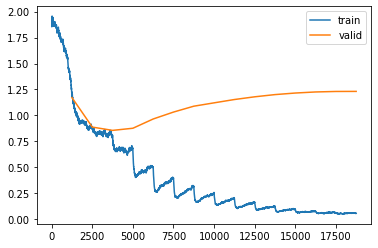

In [36]:
learn.recorder.plot_loss()

Au lieu d'être meilleur, cela finit par être pire (du moins à la fin de l'entraînement Pourquoi donc? Si nous examinons attentivement les deux formations, nous pouvons voir que la perte de validation a cessé de s'améliorer au milieu et a commencé à s'aggraver. Comme nous l'avons vu, c'est une indication claire de sur-apprentissage. Dans ce cas, il n'y a aucun moyen d'utiliser l'augmentation des données, nous devrons donc utiliser une autre technique de régularisation. Une approche qui peut être utile est la *décroissance du poids*.

### Décroissance de poids (paramètre)

La décroissance de poids, ou *régularisation L2*, consiste à ajouter à votre fonction de perte (loss) la somme de tous les poids au carré. Pourquoi faire ça? Parce que lorsque nous calculons les gradients, cela leur ajoutera une contribution qui encouragera les poids à être aussi petits que possible.

Pourquoi empêcherait-il le sur-apprentissage? L'idée est que plus les coefficients sont grands, plus les vallées seront plus pointues dans la fonction de perte. Si nous prenons l'exemple de base d'une parabole, `y = a * (x ** 2)`, plus `a` est grand, plus la parabole est *étroite* (<<paraboles>>).

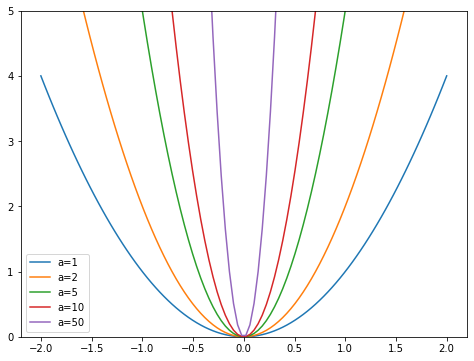

In [43]:
#hide_input
#id parabolas
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

Ainsi, laisser notre modèle apprendre des paramètres élevés pourrait l'amener à ajuster tous les points de données de l'ensemble d'apprentissage avec une fonction surcomplexe qui a des changements très brusques, ce qui entraînera un sur-apprentissage.

Empêcher nos poids de trop grandir va entraver l'apprentissage du modèle, mais cela donnera un état où il se généralise mieux. Pour revenir brièvement à la théorie, la décroissance du poids (ou simplement `wd`) est un paramètre qui contrôle cette somme de carrés que nous ajoutons à notre perte/loss (en supposant que` paramètres` est un tenseur de tous les paramètres):

``` python
loss_with_wd = perte + wd * (paramètres**2) .sum ()
```

En pratique, cependant, il serait très inefficace (et peut-être numériquement instable) de calculer cette grosse somme et de l'ajouter à la perte. Si vous vous souvenez un peu de mathématiques au lycée, vous vous souviendrez peut-être que la dérivée de `p**2` par rapport à` p` est `2*p`, donc ajouter cette grosse somme à notre perte est exactement la même que faire:

``` python
parameters.grad + = wd * 2 * paramètres
```

En pratique, puisque `wd` est un paramètre que nous choisissons, nous pouvons simplement le rendre deux fois plus grand, donc nous n'avons même pas besoin du `*2` dans cette équation. Pour utiliser la décroissance du poids dans fastai, passez simplement `wd` dans votre appel à` fit` ou `fit_one_cycle`:

In [52]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(15, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.218461,1.179585,00:08
1,0.864265,0.898841,00:08
2,0.839705,0.863571,00:08
3,0.796157,0.852406,00:09
4,0.688611,0.848301,00:09
5,0.599685,0.860030,00:10
6,0.550562,0.867554,00:08
7,0.481543,0.874333,00:08
8,0.420580,0.878628,00:08
9,0.372456,0.879094,00:08


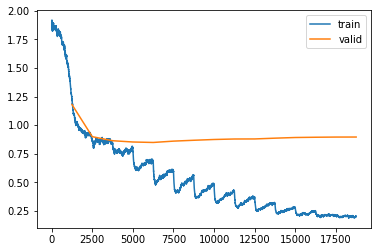

In [53]:
learn.recorder.plot_loss()

In [75]:
ratings.iloc[:,0].shape

(100000,)

In [87]:
user_vec = learn.user_factors(torch.tensor([user_idX]).cuda(0))
movie_vec = learn.movie_factors(torch.tensor([movie_idX]).cuda(0))

In [94]:
user_b = learn.user_bias(torch.tensor([user_idX]).cuda(0)) 
movie_b = learn.user_bias(torch.tensor([movie_idX]).cuda(0)) 

In [90]:
user_vec.shape, movie_vec.shape

(torch.Size([1, 50]), torch.Size([1, 50]))

In [95]:
rate_pred = user_vec[0].dot(movie_vec[0])+ movie_b + user_b

In [96]:
rate_pred

tensor([[-0.4088]], device='cuda:0', grad_fn=<AddBackward0>)

In [101]:
ratings[ratings.movie==movie_idX]

,user,movie,rating,timestamp,title
35676,181,3,2,878963441,Four Rooms (1995)
35677,81,3,4,876592546,Four Rooms (1995)
35678,160,3,3,876770124,Four Rooms (1995)
35679,130,3,5,876250897,Four Rooms (1995)
35680,49,3,3,888068877,Four Rooms (1995)
...,...,...,...,...,...
35761,859,3,5,885775513,Four Rooms (1995)
35762,917,3,1,882911567,Four Rooms (1995)
35763,699,3,3,879147917,Four Rooms (1995)
35764,910,3,2,881421019,Four Rooms (1995)


In [ ]:
learn.predict()

In [88]:
user_idX, movie_idX
# learn.
# rn.model()

(196, 3)

Much better!

### Création de notre propre module d'embedding

Jusqu'à présent, nous avons utilisé «Embedding» sans réfléchir à son fonctionnement réel. Recréons `DotProductBias` *sans* utiliser cette classe. Nous aurons besoin d'une matrice de poids initialisée au hasard pour chacun des plongements. Nous devons cependant être prudents. Rappelez-vous de <<chapter_mnist_basics>> que les optimiseurs exigent qu'ils puissent obtenir tous les paramètres d'un module à partir de la méthode `parameters` du module. Cependant, cela ne se produit pas de manière entièrement automatique. Si nous ajoutons simplement un tenseur comme attribut à un `Module`, il ne sera pas inclus dans les `paramètres`:

In [105]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

Pour dire à `Module` que nous voulons traiter un tenseur comme un paramètre, nous devons l'envelopper dans la classe` nn.Parameter`. Cette classe n'ajoute en fait aucune fonctionnalité (autre que l'appel automatique `requires_grad_` pour nous). Il est uniquement utilisé comme "marqueur" pour montrer ce qu'il faut inclure dans les `paramètres`:

In [106]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

Tous les modules PyTorch utilisent `nn.Parameter` pour tous les paramètres pouvant être entraînés, c'est pourquoi nous n'avons pas eu besoin d'utiliser explicitement ce wrapper jusqu'à présent:

In [107]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[ 0.6141],
        [-0.9455],
        [-0.9924]], requires_grad=True)]

In [108]:
type(t.a.weight)

torch.nn.parameter.Parameter

On peut créer un tenseur comme paramètre, avec une initialisation aléatoire, comme ceci:

In [109]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

Utilisons ceci pour créer à nouveau `DotProductBias`, mais sans` Embedding`:

In [110]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

Ensuite, entraînons-le à nouveau pour vérifier que nous obtenons les mêmes résultats que ceux que nous avons vus dans la section précédente:

In [111]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(15, 5e-3, wd=0.2)

epoch,train_loss,valid_loss,time
0,1.234053,1.205176,00:12
1,0.929393,0.914532,00:14
2,0.882853,0.899345,00:12
3,0.849623,0.877939,00:12
4,0.823314,0.857664,00:16
5,0.773068,0.856171,00:12
6,0.764059,0.847997,00:13
7,0.716175,0.837609,00:09
8,0.667075,0.832834,00:09
9,0.658865,0.827406,00:11


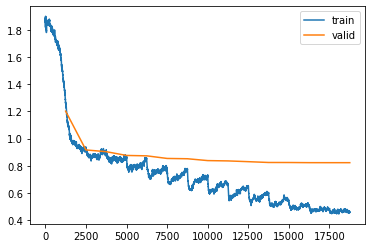

In [61]:
learn.recorder.plot_loss()

Voyons maintenant ce que notre modèle a appris.

## Interprétation des embeddings et des biais

Notre modèle est déjà utile, dans la mesure où il peut nous fournir des recommandations de films pour nos utilisateurs, mais il est également intéressant de voir quels paramètres il a découverts. Les biais sont les plus faciles à interpréter. Voici les films avec les valeurs les plus basses du vecteur de biais:

In [112]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Crow: City of Angels, The (1996)',
 'Cable Guy, The (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Mortal Kombat: Annihilation (1997)']

Pensez à ce que cela signifie. Ce qu'il dit, c'est que pour chacun de ces films, même lorsqu'un utilisateur est très bien adapté à ses facteurs latents (qui, comme nous le verrons dans un instant, ont tendance à représenter des choses comme le niveau d'action, l'âge du film, etc. ), ils n'aiment toujours pas ça. Nous aurions pu simplement trier les films directement en fonction de leur note moyenne, mais regarder le biais appris nous dit quelque chose de beaucoup plus intéressant. Cela nous dit non seulement si un film est d'un genre que les gens ont tendance à ne pas aimer regarder, mais que les gens ont tendance à ne pas aimer le regarder même si c'est d'un genre qu'ils aimeraient autrement! De la même manière, voici les films les plus biaisés:

In [113]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Star Wars (1977)',
 'Good Will Hunting (1997)']

Ainsi, par exemple, même si vous n'aimez pas normalement les films policiers, vous pourriez apprécier *LA Confidential*!

Il n'est pas si facile d'interpréter directement les matrices d'incorporation. Il y a trop de facteurs à considérer pour un être humain. Mais il existe une technique qui peut extraire les *directions* sous-jacentes les plus importantes dans une telle matrice, appelée *analyse en composantes principales* (ACP). Nous n'entrerons pas dans le détail dans ce livre, car il n'est pas particulièrement important pour vous de comprendre pour être un praticien de l'apprentissage profond, mais si vous êtes intéressé, nous vous suggérons de consulter le cours fast.ai [Computational Linear Algebra pour les codeurs](https://github.com/fastai/numerical-linear-algebra). <<img_pca_movie>> montre à quoi ressemblent nos films sur la base de deux des composantes les plus fortes de l'ACP.

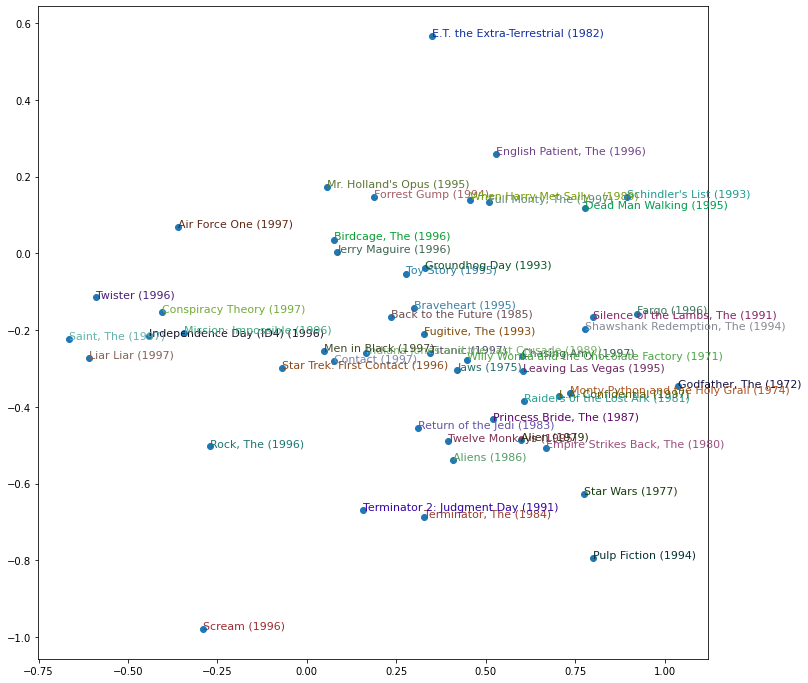

In [114]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Nous pouvons voir ici que le modèle semble avoir découvert un concept de films *classiques* contre *pop culture*, ou peut-être est-il *acclamé par la critique* qui est représenté ici.

> j: Peu importe le nombre de modèles que j'entraîne, je n'arrête jamais d'être ému et surpris par la façon dont ces groupes de nombres initialisés au hasard, entraînés avec une mécanique aussi simple, parviennent à découvrir par eux-mêmes des choses sur mes données. Cela ressemble presque à de la triche, que je peux créer du code qui fait des choses utiles sans jamais lui dire comment faire ces choses!

Nous avons défini notre modèle à partir de zéro pour vous apprendre ce qu'il y a à l'intérieur, mais vous pouvez directement utiliser la bibliothèque fastai pour le construire. Nous verrons comment procéder ensuite.

### Utilisation de fastai.collab

Nous pouvons créer et entraîner un modèle de filtrage collaboratif en utilisant la structure exacte montrée précédemment en utilisant `collab_learner` de fastai:

In [67]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [68]:
learn.fit_one_cycle(5, 5e-3, wd=0.2)

epoch,train_loss,valid_loss,time
0,0.952402,0.955807,00:10
1,0.877484,0.889582,00:10
2,0.810135,0.855335,00:10
3,0.735582,0.823191,00:10
4,0.653066,0.819282,00:10


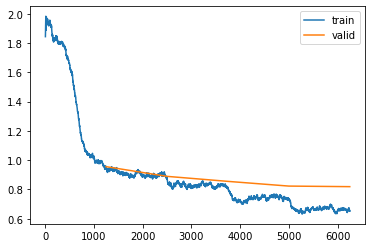

In [69]:
learn.recorderrderrderrder.plot_loss()

Les noms des couches peuvent être vus en affichant le modèle:

In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1635, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1635, 1)
)

We can use these to replicate any of the analyses we did in the previous section—for instance:

In [ ]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)']

Une autre chose intéressante que nous pouvons faire avec ces embeddings apprises est de regarder _distance_.

### Distance d'embedding

Sur une carte bidimensionnelle, nous pouvons calculer la distance entre deux coordonnées en utilisant la formule de Pythagore: $ \ sqrt {x ^ {2} + y ^ {2}} $ (en supposant que *x* et *y* sont les distances entre les coordonnées sur chaque axe). Pour un  embedding de  dimensions 50, nous pouvons faire exactement la même chose, sauf que nous additionnons les carrés des 50 distances de coordonnées.

S'il y avait deux films presque identiques, alors leurs vecteurs d'intégration devraient également être presque identiques, car les utilisateurs qui les aimeraient seraient presque exactement les mêmes. Il y a une idée plus générale ici: la similitude des films peut être définie par la similitude des utilisateurs qui aiment ces films. Et cela signifie directement que la distance entre les vecteurs d'embedding de deux films peut définir cette similitude. Nous pouvons l'utiliser pour trouver le film le plus similaire à *Silence of the Lambs*:

In [70]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'To Catch a Thief (1955)'

Maintenant que nous avons formé avec succès un modèle, voyons comment gérer la situation où nous n'avons pas de données pour un utilisateur. Comment faire des recommandations aux nouveaux utilisateurs?

## Amorcer un modèle de filtrage collaboratif

Le plus grand défi de l'utilisation des modèles de filtrage collaboratif dans la pratique est le *problème du bootstrap*. La version la plus extrême de ce problème se produit lorsque vous n'avez pas d'utilisateurs, et donc pas d'historique à apprendre. Quels produits recommandez-vous à votre tout premier utilisateur?

Mais même si vous êtes une entreprise bien établie avec une longue histoire de transactions d'utilisateurs, vous vous posez toujours la question: que faites-vous lorsqu'un nouvel utilisateur s'inscrit? Et en effet, que faites-vous lorsque vous ajoutez un nouveau produit à votre portefeuille? Il n'y a pas de solution magique à ce problème, et en réalité les solutions que nous suggérons ne sont que des variantes de *utilisez votre bon sens*. Vous pouvez attribuer aux nouveaux utilisateurs la moyenne de tous les vecteurs d'intégration de vos autres utilisateurs, mais cela pose le problème que cette combinaison particulière de facteurs latents peut ne pas être du tout courante (par exemple, la moyenne du facteur de science-fiction peut être élevé, et la moyenne du facteur d’action peut être faible, mais il n’est pas si courant de trouver des gens qui aiment la science-fiction sans action). Le mieux serait probablement de choisir un utilisateur particulier pour représenter le *goût moyen*.

Mieux encore, utilisez un modèle tabulaire basé sur les métadonnées utilisateur pour construire votre vecteur d'intégration initial. Lorsqu'un utilisateur s'inscrit, réfléchissez aux questions que vous pourriez lui poser et qui pourraient vous aider à comprendre ses goûts. Vous pouvez ensuite créer un modèle dans lequel la variable dépendante est le vecteur d'intégration d'un utilisateur, et les variables indépendantes sont les résultats des questions que vous leur posez, ainsi que leurs métadonnées d'inscription. Nous verrons dans la section suivante comment créer ces types de modèles tabulaires. (Vous avez peut-être remarqué que lorsque vous vous inscrivez à des services tels que Pandora et Netflix, ils ont tendance à vous poser quelques questions sur les genres de films ou de musique que vous aimez; c'est ainsi qu'ils élaborent vos recommandations initiales de filtrage collaboratif.)

Une chose à laquelle il faut faire attention est qu'un petit nombre d'utilisateurs extrêmement enthousiastes peuvent finir par définir efficacement les recommandations pour l'ensemble de votre base d'utilisateurs. C'est un problème très courant, par exemple, dans les systèmes de recommandation de films. Les gens qui regardent des anime ont tendance à en regarder beaucoup, à ne pas regarder grand-chose d'autre et à passer beaucoup de temps à mettre leurs notes sur des sites Web. En conséquence, l'anime a tendance à être fortement surreprésenté dans de nombreuses listes de *meilleurs films de tous les temps*. Dans ce cas particulier, il peut être assez évident que vous ayez un problème de biais de représentation, mais si le biais se produit dans les facteurs latents, cela peut ne pas être évident du tout.

Un tel problème peut modifier l'ensemble de la composition de votre base d'utilisateurs et le comportement de votre système. Cela est particulièrement vrai en raison des boucles de rétroaction( feedback loops) positives. Si un petit nombre de vos utilisateurs ont tendance à définir l'orientation de votre système de recommandation, ils finiront naturellement par attirer plus de personnes comme eux dans votre système. Et cela amplifiera bien sûr le biais de représentation d'origine. Ce type de biais a une tendance naturelle à être amplifié de façon exponentielle. Vous avez peut-être vu des exemples de dirigeants d'entreprise s'étonnant de la façon dont leurs plateformes en ligne se sont rapidement détériorées de telle sorte qu'ils ont exprimé des valeurs en contradiction avec les valeurs des fondateurs. En présence de ces types de boucles de rétroaction, il est facile de voir comment une telle divergence peut se produire à la fois rapidement et de manière cachée jusqu'à ce qu'il soit trop tard.

Dans un système auto-renforçant comme celui-ci, nous devrions probablement nous attendre à ce que ces types de boucles de rétroaction soient la norme, pas l'exception. Par conséquent, vous devez supposer que vous les verrez, planifierez pour cela et identifier dès le départ comment vous allez traiter ces problèmes. Essayez de réfléchir à toutes les façons dont les boucles de rétroaction peuvent être représentées dans votre système et à la façon dont vous pourriez être en mesure de les identifier dans vos données. En fin de compte, cela revient à nos conseils originaux sur la façon d'éviter un désastre lors du déploiement de tout type de système d'apprentissage automatique. Il s'agit de s'assurer qu'il y a des humains dans la boucle; qu'il y a une surveillance attentive et un déploiement progressif et réfléchi.

Notre modèle de produit scalaire fonctionne très bien et il est à la base de nombreux systèmes de recommandation réussis dans le monde réel. Cette approche du filtrage collaboratif est connue sous le nom de *factorisation matricielle probabiliste* (PMF). Une autre approche, qui fonctionne généralement de manière similaire avec les mêmes données, est l'apprentissage profond.

## Deep Learning pour le Filtrage Collaboratif

Pour transformer notre architecture en un modèle d'apprentissage profond, la première étape consiste à prendre les résultats de la recherche d'embedding et à concaténer ces activations ensemble. Cela nous donne une matrice que nous pouvons ensuite passer à travers des couches linéaires et des non-linéarités de la manière habituelle.

Puisque nous concaténerons les matrices d'embedding, plutôt que de prendre leur produit scalaire, les deux matrices d'embedding peuvent avoir des tailles différentes (c'est-à-dire des nombres différents de facteurs latents). fastai a une fonction `get_emb_sz` qui renvoie les tailles recommandées de matrices d'embedding pour vos données, basée sur une heuristique que fast.ai a trouvé qu'elle a tendance à bien fonctionner en pratique:

In [71]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

Implémentons cette classe:

In [74]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

Et utilisons-la pour créer un modèle:

In [75]:
model = CollabNN(*embs)

`CollabNN` crée nos couches ` Embedding` de la même manière que les classes précédentes de ce chapitre, sauf que nous utilisons maintenant les tailles `embs`. `self.layers` est identique au mini-réseau neuronal que nous avons créé dans <<chapter_mnist_basics>> pour MNIST. Ensuite, dans `forward`, nous appliquons les embeddings, concaténons les résultats et les transmettons à travers le réseau mini-neuronal. Enfin, nous appliquons `sigmoid_range` comme nous l'avons fait dans les modèles précédents.

Voyons si ça s'entraîne:

In [76]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.935593,0.948893,00:12
1,0.905827,0.906412,00:12
2,0.876506,0.880452,00:11
3,0.806066,0.870857,00:11
4,0.777238,0.874802,00:11


fastai fournit ce modèle dans `fastai.collab` si vous passez` use_nn = True` dans votre appel à `collab_learner` (y compris en appelant` get_emb_sz` pour vous), et il vous permet de créer facilement plus de couches. Par exemple, nous créons ici deux couches cachées, de taille 100 et 50, respectivement:

In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.002747,0.972392,00:16
1,0.926903,0.922348,00:16
2,0.877160,0.893401,00:16
3,0.838334,0.865040,00:16
4,0.781666,0.864936,00:16


`learn.model` est un objet de type` EmbeddingNN`. Jetons un coup d'œil au code de fastai pour cette classe:

In [77]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

Wow, ce n'est pas beaucoup de code! Cette classe *hérite* de `TabularModel`, d'où elle tire toutes ses fonctionnalités. Dans `__init__`, il appelle la même méthode dans` TabularModel`, en passant `n_cont = 0` et` out_sz = 1`; à part cela, il ne transmet que les arguments qu'il a reçus.

### Sidebar: `kwargs` et `delegates`

`EmbeddingNN` inclut `** kwargs` comme paramètre de `__init__`. En Python, `** kwargs` dans une liste de paramètres signifie «mettre tout argument de mot-clé supplémentaire dans un dict appelé `kwargs`. Et `** kwargs` une liste d'arguments signifie « insérer toutes les paires clé / valeur dans le dict de `kwargs` comme arguments nommés ici ». Cette approche est utilisée dans de nombreuses bibliothèques populaires, telles que ` matplotlib`, dans lesquelles la fonction principale `plot` a simplement la signature `plot (* args, ** kwargs) `. Le [` plot` documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot) dit "Les` kwargs` sont des propriétés `Line2D` "puis liste ces propriétés.

Nous utilisons `** kwargs` dans` EmbeddingNN` pour éviter d'avoir à écrire tous les arguments dans `TabularModel` une deuxième fois et les garder synchronisés. Cependant, cela rend notre API assez difficile à utiliser, car maintenant Jupyter Notebook ne sait pas quels paramètres sont disponibles. Par conséquent, des éléments tels que la complétion par tabulation des noms de paramètres et les listes contextuelles de signatures ne fonctionneront pas.

fastai résout ce problème en fournissant un décorateur spécial `@ delegates`, qui change automatiquement la signature de la classe ou de la fonction (` EmbeddingNN` dans ce cas) pour insérer tous ses arguments de mots-clés dans la signature.

### End sidebar

Bien que les résultats de `EmbeddingNN` soient un peu pires que l'approche du produit scalaire (qui montre le pouvoir de construire soigneusement une architecture pour un domaine), cela nous permet de faire quelque chose de très important: nous pouvons maintenant incorporer directement des informations d'autres utilisateurs et  de films , des informations sur la date et l'heure, ou toute autre information pouvant être pertinente pour la recommandation. C'est exactement ce que fait `TabularModel`. En fait, nous avons maintenant vu que `EmbeddingNN` est juste un` TabularModel`, avec `n_cont = 0` et` out_sz = 1`. Donc, nous ferions mieux de passer un peu de temps à apprendre sur `TabularModel`, et comment l'utiliser pour obtenir d'excellents résultats! Nous ferons cela dans le prochain chapitre.

## Conclusion

Pour notre première application de vision non par ordinateur, nous avons examiné les systèmes de recommandation et vu comment la descente de gradient peut apprendre des facteurs intrinsèques ou des biais sur des éléments à partir d'un historique des évaluations. Ceux-ci peuvent alors nous donner des informations sur les données.

Nous avons également construit notre premier modèle dans PyTorch. Nous en ferons beaucoup plus dans la prochaine section du livre, mais d'abord, terminons notre plongée dans les autres applications générales de l'apprentissage en profondeur, en continuant avec les données tabulaires.

## Questionnaire

1. Quel problème le filtrage collaboratif résout-il?
1. Comment le résout-il?
1. Pourquoi un modèle prédictif de filtrage collaboratif pourrait-il ne pas être un système de recommandation très utile?
1. À quoi ressemble une représentation croisée des données de filtrage collaboratif?
1. Écrivez le code pour créer une représentation croisée des données MovieLens (vous devrez peut-être effectuer une recherche sur le Web!).
1. Qu'est-ce qu'un facteur latent? Pourquoi est-ce «latent»?
1. Qu'est-ce qu'un produit scalaire? Calculez manuellement un produit scalaire en utilisant du Python pur avec des listes.
1. Que fait `pandas.DataFrame.merge`?
1. Qu'est-ce qu'une matrice d'intégration?
1. Quelle est la relation entre une Embedding et une matrice de vecteurs à un codage one-hot?
1. Pourquoi avons-nous besoin de «Embedding» si nous pouvons utiliser des vecteurs encodés one-hot pour la même chose?
1. Que contient un Embedding avant de commencer l'entraînement (en supposant que nous n'utilisons pas un modèle pré-entraîné)?
1. Créez une classe (sans jeter un œil, si possible!) Et utilisez-la.
1. Que renvoie `x [:, 0]`?
1. Réécrivez la classe «DotProduct» (sans jeter un œil, si possible!) Et entraînez un modèle avec.
1. Quelle est la bonne fonction de perte (loss) à utiliser pour MovieLens? Pourquoi?
1. Que se passerait-il si nous utilisions la perte d'entropie croisée avec MovieLens? Comment devrions-nous changer le modèle?
1. À quoi sert le biais dans un modèle de produit scalaire?
1. Quel est un autre nom pour la perte de poids?
1. Écris l'équation de la décroissance du poids (sans jeter un œil!).
1. Écris l'équation du gradient de décroissance du poids. Pourquoi cela aide-t-il à réduire le poids?
1. Pourquoi la réduction des poids conduit-elle à une meilleure généralisation?
1. Que fait «argsort» dans PyTorch?
1. Le tri des biais de films donne-t-il le même résultat que la moyenne des classements globaux des films par film? Pourquoi/pourquoi pas?
1. Comment affichez-vous les noms et les détails des couches dans un modèle?
1. Quel est le «problème du bootstrap» dans le filtrage collaboratif?
1. Comment pouvez-vous gérer le problème du bootstrap pour les nouveaux utilisateurs? Pour de nouveaux films?
1. Comment les boucles de rétroaction peuvent-elles avoir un impact sur les systèmes de filtrage collaboratifs?
1. Lors de l'utilisation d'un réseau neuronal dans le filtrage collaboratif, pourquoi pouvons-nous avoir différents nombres de facteurs pour les films et les utilisateurs?
1. Pourquoi y a-t-il un «nn.Sequential» dans le modèle «CollabNN»?
1. Quel type de modèle devrions-nous utiliser si nous voulons ajouter des métadonnées sur les utilisateurs et les éléments, ou des informations telles que la date et l'heure, à un modèle de filtrage collaboratif?

### De plus amples recherches

1. Jetez un œil à toutes les différences entre la version `Embedding` de` DotProductBias` et la version `create_params`, et essayez de comprendre pourquoi chacune de ces modifications est nécessaire. Si vous n'êtes pas sûr, essayez d'annuler chaque modification pour voir ce qui se passe. (NB: même le type de parenthèse utilisé dans `forward` a changé!)
1. Trouvez trois autres domaines dans lesquels le filtrage collaboratif est utilisé et découvrez quels sont les avantages et les inconvénients de cette approche dans ces domaines.
1. Complétez ce notebook à l'aide de l'ensemble de données MovieLens complet et comparez vos résultats aux benchmarks en ligne. Voyez si vous pouvez améliorer votre précision. Consultez le site Web du livre et le forum fast.ai pour trouver des idées. Notez qu'il y a plus de colonnes dans l'ensemble de données complet - voyez si vous pouvez également les utiliser (le chapitre suivant pourrait vous donner des idées).
1. Créez un modèle pour MovieLens qui fonctionne avec une perte d'entropie croisée et comparez-le au modèle de ce chapitre.